# EDA

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from skimage.measure import label, regionprops
import seaborn as sns

sns.set(style='whitegrid')

In [2]:
BASE_DIR = "/kaggle/input/recodai-luc-scientific-image-forgery-detection"

In [3]:
train_image_paths = sorted(glob(os.path.join(BASE_DIR, "train_images", "*", "*.png")))
train_mask_paths = sorted(glob(os.path.join(BASE_DIR, "train_masks", "*.npy")))

In [4]:
print(f"This is a size of train image {len(train_image_paths)} and this is a size mask, {len(train_mask_paths)}")

This is a size of train image 5128 and this is a size mask, 2751


In [5]:
def get_id(path):
    return os.path.splitext(os.path.basename(path))[0]

mask_map = {get_id(p): p for p in train_mask_paths}


In [6]:
pairs = []

for img_path in train_image_paths:
    cid = get_id(img_path)

    if cid in mask_map:
        mask_path = mask_map[cid]
        has_forgery = True
    else:
        mask_path = None   # authentic
        has_forgery = False

    pairs.append({
        "img_path": img_path,
        "mask_path": mask_path,
        "has_forgery": has_forgery
    })


print(f"Total images: {len(pairs)}")
print(f"Total forged images: {sum(p['has_forgery'] for p in pairs)}")
print(f"Total authentic images: {len(pairs) - sum(p['has_forgery'] for p in pairs)}")


Total images: 5128
Total forged images: 5128
Total authentic images: 0


In [7]:
fg_ratios = []
n_components = []

for p in pairs:
    if not p["has_forgery"]:
        continue
    mask = np.load(p["mask_path"])
    fg_ratios.append(mask.mean())
    labeled = label(mask)
    n_components.append(len(regionprops(labeled)))

In [8]:
auth_ratio = 1 - (len(fg_ratios)/len(pairs))
median_fg_ratio = np.median(fg_ratios)
mean_components = np.mean(n_components)

print(f"Authentic ratio: {auth_ratio:.4f}")
print(f"Median foreground ratio in forged images: {median_fg_ratio:.4f}")
print(f"Mean number of connected components per forged image: {mean_components:.2f}")

Authentic ratio: 0.0000
Median foreground ratio in forged images: 0.0213
Mean number of connected components per forged image: 3.12


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


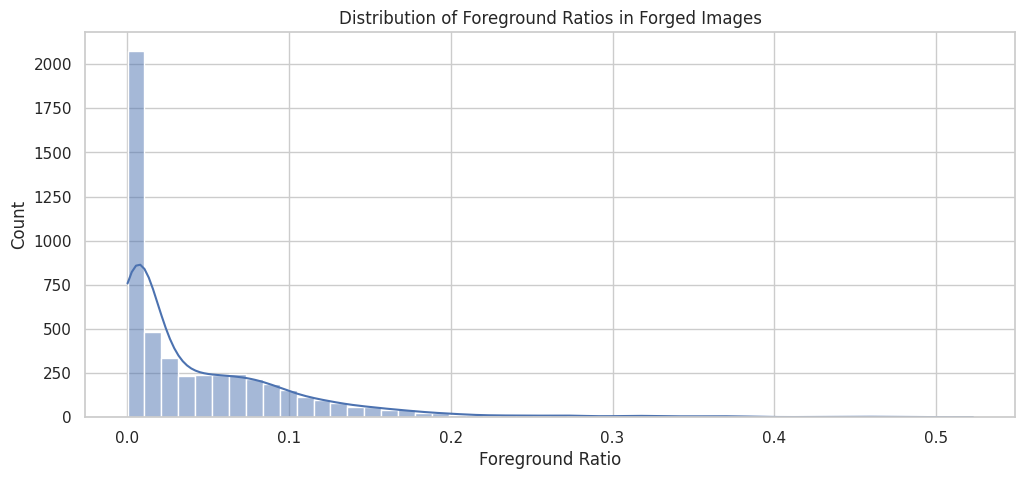

In [9]:
plt.figure(figsize=(12,5))
sns.histplot(fg_ratios, bins=50, kde=True)
plt.title("Distribution of Foreground Ratios in Forged Images")
plt.xlabel("Foreground Ratio")
plt.ylabel("Count")
plt.show()




/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


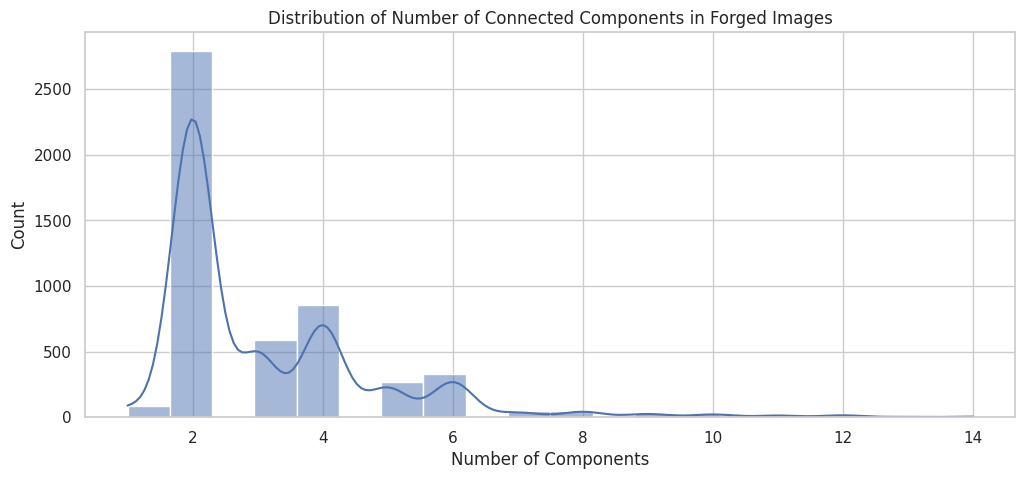

In [10]:
plt.figure(figsize=(12,5))
sns.histplot(n_components, bins=20, kde=True)
plt.title("Distribution of Number of Connected Components in Forged Images")
plt.xlabel("Number of Components")
plt.ylabel("Count")
plt.show()

In [11]:
def show_samples(pairs, n=6):
    forged_samples = [p for p in pairs if p["has_forgery"]]
    authentic_samples = [p for p in pairs if not p["has_forgery"]]

    samples = forged_samples[:n//2] + authentic_samples[:n//2]

    plt.figure(figsize=(16,6))
    for i, p in enumerate(samples):
        img = cv2.imread(p["img_path"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if p["has_forgery"]:
            mask = np.load(p["mask_path"])
            overlay = img.copy()
            overlay[mask==1] = [255,0,0]  # red mask overlay
            img_to_show = cv2.addWeighted(img, 0.7, overlay, 0.3, 0)
        else:
            img_to_show = img

        plt.subplot(2, n//2, i+1)
        plt.imshow(img_to_show)
        plt.axis("off")
        plt.title("Forged" if p["has_forgery"] else "Authentic")
    plt.show()
